### Imports

In [5]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

### Graphs

In [6]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Input Pipeline

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print(train_dataset.element_spec)

for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2024-10-08 23:02:53.256387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-08 23:02:53.256936: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'It\'s pretty bad when the generic movie synopsis has more information than the film itself. The paragraph-long "plot summary" written on the movie page has details I could not glean from watching the actual movie. I found myself constantly backing it up to see what details I had just missed which could tell me what the (bleep) was going on. Alas, to no avail--this movie leaves out monstrous pieces of the story, if you could call it a story. It\'s like they were trying to fool us into thinking that there was some kind of movie here, filming just enough so that there was the resemblance of a story and leaving the rest to our imaginations. Newsflash to the the creators: I paid to watch you MAKE a movie. I can sit home and imagine plots and story lines for free. And Rosario Dawson? This is somebody I\'ve never paid enough attention to to be able to put the name to the face, and I can see why. She had one of the most artificial performances I have ever seen for a leading characte

2024-10-08 23:03:01.574014: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-08 23:03:01.579042: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Create the text encoder

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [14]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 30, 179,  84, ...,   0,   0,   0],
       [ 11,  20,  44, ...,   0,   0,   0],
       [ 45,  23, 116, ...,   0,   0,   0]])

#### Create the model

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
])

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, False]


In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train the model

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 294s 749ms/step - accuracy: 0.5122 - loss: 0.6828 - val_accuracy: 0.7453 - val_loss: 0.5609
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 303s 775ms/step - accuracy: 0.7545 - loss: 0.5055 - val_accuracy: 0.8276 - val_loss: 0.3814
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 292s 746ms/step - accuracy: 0.8279 - loss: 0.3859 - val_accuracy: 0.8526 - val_loss: 0.3402
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 295s 753ms/step - accuracy: 0.8494 - loss: 0.3465 - val_accuracy: 0.8417 - val_loss: 0.3421
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 318s 815ms/step - accuracy: 0.8640 - loss: 0.3205 - val_accuracy: 0.8151 - val_loss: 0.3616
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 307s 786ms/step - accuracy: 0.8573 - loss: 0.3262 - val_accuracy: 0.8479 - val_loss: 0.3416
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 312s 798ms/step - accuracy: 0.8633 - loss: 0.3165 - val_accuracy: 0.8495 - val_loss: 0.3177
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 314s 804ms/step - accuracy: 0.8690 -

2024-10-08 23:54:37.674278: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 64)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,109 (1.58 MB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,740 (1.06 MB)

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 152ms/step - accuracy: 0.8477 - loss: 0.3226
Test Loss: 0.3226422965526581
Test Accuracy: 0.8474799990653992


(0.0, 0.6705100581049919)

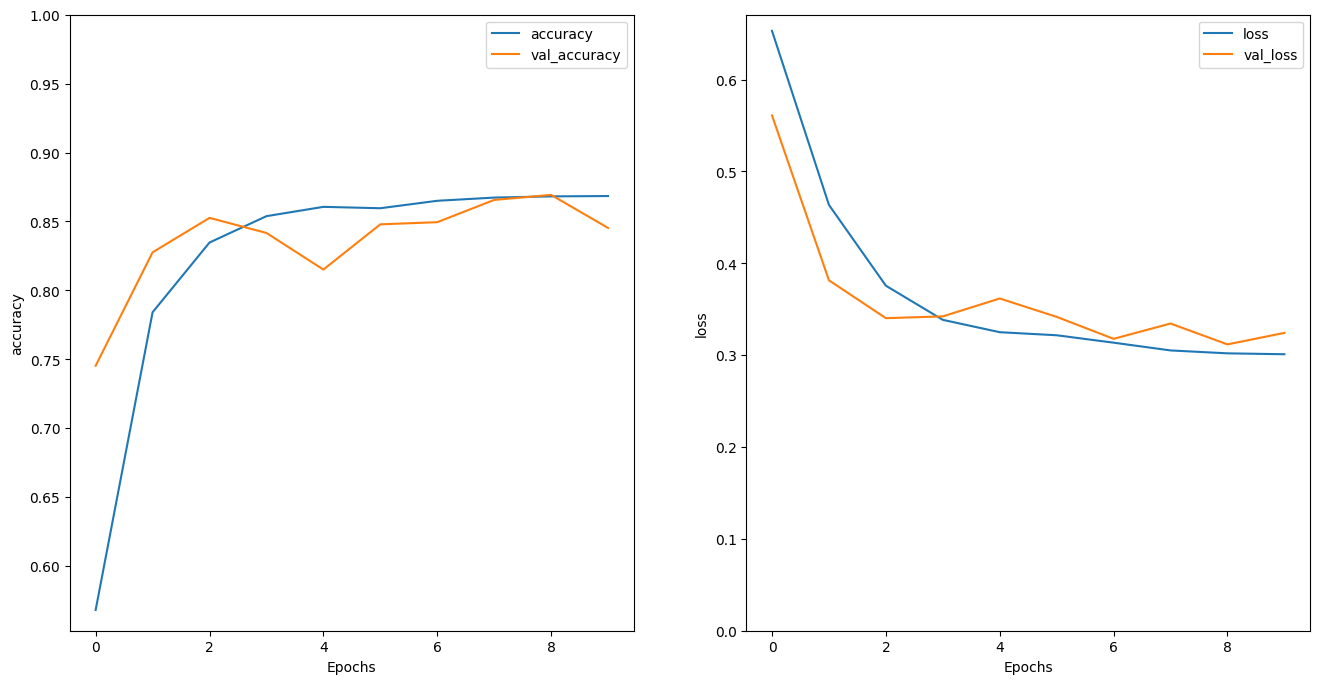

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Prediction

In [25]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

input_text = tf.constant([sample_text])
predictions = model.predict(input_text)
print(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
[0.865163]


In [28]:
model_json = model.to_json()
with open("model.json", "w") as js:
    js.write(model_json)
    
model.save("my_model.keras")